<div align="center">
<h1 style="color:#2c3e50;">🧠 Tesis Final de Master</h1>
<h2 style="color:#34495e;">Evaluación Sesgos en Compas</h2>
<h3 style="color:#34495e;">Análisis de los puntajes de Compas y desarrollo de un modelo de predicción simple</h3>

<img src="https://tecscience.tec.mx/es/wp-content/uploads/sites/8/2023/04/algoritmo-de-riesgo-criminal.jpg" width="800">

**Nuclio Digital School**  
*TFM curso presencial marzo 2025*

---

**Autor:** Azahara Bravo, Daniel Álvarez y María Loza

**Fecha:** 3 de octubre, 2025  
**Versión:** 1.0  

</div>

<hr style="border:none; height:2px; background:linear-gradient(to right, #3498db, #e74c3c, #f39c12);">

<hr style="border:none; height:1px; background:#ddd;">

<div style="text-align:center; margin:20px 0;">
• • • •
</div>

# 0. **INTRODUCCIÓN**


Este notebook desarrolla los apartados 3 y 4 propuestos por Nuclio del TFM, siguiendo la metodología acordada.  
Cada subapartado incluye: introducción, código en Python y un insight interpretativo.

---

### 1 — Evaluación de los puntajes de COMPAS

- **1.1 Preparación del notebook**  
  Carga del dataset `compas_twoyears.csv`, verificación de columnas clave y limpieza mínima.

- **1.2 Definición de la variable de predicción binaria y matriz de confusión global**  
  Transformación del score en una predicción binaria (bajo riesgo 1–4, alto riesgo 5–10).  
  Construcción de la matriz de confusión global para evaluar aciertos y errores.  
  Introducción de la idea de segmentar también por demografía.

- **1.3 Matrices de confusión por demografía**  
  Generación de matrices completas (TN, FP, FN, TP) para etnia, género y rango de edad.  
  Observación de cómo se distribuyen los errores dentro de cada colectivo.

- **1.4 Comparación de tasas por grupos demográficos**  
  Cálculo de tasas de acierto (TPR/Recall) y de error (FPR) para etnia, género y rango de edad.  
  Identificación de diferencias en el desempeño de COMPAS entre colectivos.

- **1.5 Métricas adicionales (Accuracy, Precision, Recall, F1, AUC)**  
  Evaluación de métricas globales y desagregadas por grupo demográfico.  
  Análisis comparativo para detectar desigualdades en desempeño.

- **1.6 Calibración por decil**  
  Comparación entre riesgo predicho (score/10) y tasa real de reincidencia.  
  Cálculo del gap y del error medio absoluto (MAE) a nivel global y por grupos (género, edad, etnia).  
  Evaluación de la coherencia de los scores.

- **1.7 Conclusiones**  
  Síntesis de hallazgos: desempeño moderado y desigualdad en el sistema COMPAS.

---

### 2 — Desarrollo de un modelo predictivo simple

- **2.1 Entrenamiento de un modelo de regresión logística**  
  Preparación de datos, codificación de variables categóricas, división train/test.  
  Entrenamiento de la regresión logística con `reincide` como variable target y evaluación inicial con curva ROC (AUC).

- **2.2 Comparación global entre COMPAS y la regresión logística**  
  Comparación de métricas globales (Accuracy, Precision, Recall, F1, AUC).  
  Tabla comparativa y gráfico de barras.

- **2.3 Comparación por grupos demográficos**  
  Cálculo y comparación de métricas (en especial Recall/TPR) de COMPAS y la regresión logística según etnia, género y rango de edad.  
  Análisis de las disparidades que persisten en ambos modelos.

- **2.4 Cierre**  
  Resumen de hallazgos: la regresión logística ofrece un rendimiento similar al de COMPAS,  
  pero ninguna de las dos elimina los sesgos, lo que confirma la necesidad de explorar métodos adicionales de mitigación.


In [92]:
# === Importación de librerías ===

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Métricas y evaluación
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

<hr style="border:none; height:2px; background:linear-gradient(to right, #3498db, #e74c3c, #f39c12);">

<hr style="border:none; height:1px; background:#ddd;">

<div style="text-align:center; margin:20px 0;">
 • • • •
</div>

# **1. EVALUACIÓN DE LOS PUNTAJES DE COMPAS**

___

## **1.1 PREPARACIÓN DEL NOTEBOOK: carga y preparación de datos**


En este primer paso se realiza la carga y validación inicial del dataset `compas_twoyears.csv`.  
El objetivo es asegurar que la información esté lista para los análisis posteriores sobre la eficacia y los posibles sesgos del sistema COMPAS.  

Las tareas principales de esta sección son:

- **Lectura del dataset** en un DataFrame de pandas.  
- **Verificación de columnas clave**: `sexo`, `edad`, `rango_edad`, `etnia`, `puntaje_decile`, `reincidencia_2anios`.  
- **Revisión de tipos de datos** y detección de valores ausentes en dichas variables.  
- **Exploración preliminar** de la distribución de `puntaje_decile` y del balance de la variable objetivo `reincidencia_2anios`.  

Este paso de preparación es esencial porque garantiza que los datos se encuentran en condiciones adecuadas para el análisis de desempeño y de sesgos que se desarrollarán en los apartados siguientes.


In [2]:
# 1.1 — Preparación del notebook: carga de datos

import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Carga del dataset limpio ---
df_twoyears = pd.read_csv(r"C:\Users\Azahara\Documents\NUCLIO\PROYECTO FINAL\notebooks\compas_twoyears.csv", 
    low_memory=False
)

print("✅ Dataset cargado. Shape:", df_twoyears.shape)

# --- 2) Conversión de variables clave a tipo booleano ---
# Convertimos 'reincide' y 'reincidencia_general' a booleanos
for col in ["reincide", "reincidencia_general"]:
    if col in df_twoyears.columns:
        df_twoyears[col] = df_twoyears[col].astype(bool)

# --- 3) Comprobación de tipos de datos ---
print("\nTipos de datos actualizados (subset de columnas clave):")
cols_check = [c for c in ["genero", "edad", "rango_edad", "etnia", "resultado_compas", "reincide", "reincidencia_general"] if c in df_twoyears.columns]
print(df_twoyears[cols_check].dtypes)



✅ Dataset cargado. Shape: (7214, 53)

Tipos de datos actualizados (subset de columnas clave):
genero                  object
edad                     int64
rango_edad              object
etnia                   object
resultado_compas         int64
reincide                  bool
reincidencia_general      bool
dtype: object


Aqui diras que los valores bool no estan tal cual y que hace falta convertir. 
Diras tambien que no hace falta convertir datetime pq en esta fase no nos van a inetersar esas columnas


In [ ]:
# 1.1 — Preparación del notebook: carga de datos

# --- 1) Carga del dataset limpio (ya preparado en otro notebook) ---
df_twoyears = pd.read_csv(
    "/Users/danielalejandroalvarez/Documents/Master Nuclio Python/TFM-Compas/data/compas_twoyears.csv", 
    low_memory=False
)

print("✅ Dataset cargado. Shape:", df_twoyears.shape)

# --- 2) Conversión de variables clave a tipo booleano ---
# Convertimos 'reincide' y 'reincidencia_general' a booleanos
for col in ["reincide", "reincidencia_general"]:
    if col in df_twoyears.columns:
        df_twoyears[col] = df_twoyears[col].astype(bool)

# --- 3) Comprobación de tipos de datos ---
print("\nTipos de datos actualizados (subset de columnas clave):")
cols_check = [c for c in ["genero", "edad", "rango_edad", "etnia", "resultado_compas", "reincide", "reincidencia_general"] if c in df_twoyears.columns]
print(df_twoyears[cols_check].dtypes)



✅ Dataset cargado. Shape: (7214, 53)

Tipos de datos actualizados (subset de columnas clave):
genero                  object
edad                     int64
rango_edad              object
etnia                   object
resultado_compas         int64
reincide                  bool
reincidencia_general      bool
dtype: object


**Insight 1.1 — Preparación de los datos**

La validación confirmó que todas las variables clave (`genero`, `edad`, `rango_edad`, `etnia`, `resultado_compas`, `reincide`) están presentes y con el tipo de dato adecuado.  
La limpieza eliminó registros con valores faltantes en estas columnas, dejando un dataset consistente que será la base para los análisis posteriores.  
Este paso asegura que los resultados de las métricas de desempeño y sesgo no se vean afectados por problemas de integridad en los datos.


---

## **1.2 DEFINICIÓN DE LA PREDICCIÓN BINARIA Y MATRIZ DE CONFUSIÓN GLOBAL**



En este apartado se establece la forma en que se evaluará COMPAS como clasificador binario.  
Para ello, se parte de la variable `resultado_compas` como score (1–10) y se define un umbral estándar utilizado en la literatura:  
- **Alto riesgo**: valores de 5 a 10.  
- **Bajo riesgo**: valores de 1 a 4.  

Este criterio permite transformar el score en una predicción binaria de reincidencia esperada.  
Posteriormente, se comparan estas predicciones con la variable real `reincide`, construyendo la **matriz de confusión global**, que resume los aciertos y errores del sistema COMPAS sin distinguir grupos demográficos.


In [ ]:
# 1.2 — Definición de la predicción binaria y matriz de confusión global 

# --- 1) Definir la predicción binaria a partir de resultado_compas ---
# Umbral estándar: 1–4 = Bajo (0), 5–10 = Alto (1)
df_twoyears["prediccion_compas"] = (df_twoyears["resultado_compas"] >= 5).astype(int)

# --- 2) Variable real de reincidencia ---
y_true = df_twoyears["reincide"]
y_pred = df_twoyears["prediccion_compas"]

# --- 3) Matriz de confusión ---
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

print("Matriz de confusión (filas = valor real, columnas = predicción):")
print("            Pred: No    Pred: Sí")
print("Real No  ", cm[0][0], "      ", cm[0][1])
print("Real Sí  ", cm[1][0], "      ", cm[1][1])


Matriz de confusión (filas = valor real, columnas = predicción):
            Pred: No    Pred: Sí
Real No   2681        1282
Real Sí   1216        2035


**Insight 3.2 — Matriz de confusión global**

La matriz de confusión muestra cuántas predicciones de COMPAS son correctas y cuántas son errores al clasificar a las personas como de “alto riesgo” (reincidencia) o “bajo riesgo” (no reincidencia).  

- **Verdaderos negativos (TN):** personas que no reincidieron y COMPAS predijo bajo riesgo.  
- **Falsos positivos (FP):** personas que no reincidieron pero COMPAS las clasificó como alto riesgo.  
- **Falsos negativos (FN):** personas que sí reincidieron pero COMPAS las clasificó como bajo riesgo.  
- **Verdaderos positivos (TP):** personas que reincidieron y COMPAS las clasificó como alto riesgo.  

Este resultado ofrece una primera medida global del desempeño de COMPAS, sin distinguir aún entre grupos demográficos.


___

## **1.3 MATRICES DE CONFUSIÓN POR DEMOGRAFÍA**



Tras construir la matriz de confusión global, en este apartado se generan **matrices de confusión segmentadas por variables demográficas**: etnia, género y rango de edad.  
El objetivo es observar de forma más detallada cómo se distribuyen los aciertos (TN y TP) y los errores (FP y FN) de COMPAS dentro de cada colectivo.  

Este análisis complementa la visión global, permitiendo identificar si ciertos grupos soportan más falsos positivos o falsos negativos, lo que puede evidenciar sesgos en el desempeño del sistema.


In [ ]:
# 1.3 (opcional) — Matrices de confusión por demografía



def matriz_por_grupo(df, grupo_col, y_true_col="reincide", y_score_col="resultado_compas"):
    """
    Imprime matrices de confusión para cada grupo de la variable indicada.
    """
    for grupo, datos in df.groupby(grupo_col):
        y_true = datos[y_true_col]
        y_pred = (datos[y_score_col] >= 5).astype(int)  # umbral estándar 5–10 = alto riesgo

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        print(f"\nMatriz de confusión — {grupo_col}: {grupo}")
        print("            Pred: No    Pred: Sí")
        print("Real No  ", cm[0][0], "      ", cm[0][1])
        print("Real Sí  ", cm[1][0], "      ", cm[1][1])



In [83]:
# Matrices de confusión por ETNIA
print("=== Matrices por ETNIA ===")
matriz_por_grupo(df_twoyears, "etnia")




=== Matrices por ETNIA ===

Matriz de confusión — etnia: African-American
            Pred: No    Pred: Sí
Real No   990        805
Real Sí   532        1369

Matriz de confusión — etnia: Asian
            Pred: No    Pred: Sí
Real No   21        2
Real Sí   3        6

Matriz de confusión — etnia: Caucasian
            Pred: No    Pred: Sí
Real No   1139        349
Real Sí   461        505

Matriz de confusión — etnia: Hispanic
            Pred: No    Pred: Sí
Real No   318        87
Real Sí   129        103

Matriz de confusión — etnia: Native American
            Pred: No    Pred: Sí
Real No   5        3
Real Sí   1        9

Matriz de confusión — etnia: Other
            Pred: No    Pred: Sí
Real No   208        36
Real Sí   90        43


In [84]:
# Ejecuta por separado para ver solo género
print("=== Matrices por GÉNERO ===")
matriz_por_grupo(df_twoyears, "genero")


=== Matrices por GÉNERO ===

Matriz de confusión — genero: Female
            Pred: No    Pred: Sí
Real No   609        288
Real Sí   195        303

Matriz de confusión — genero: Male
            Pred: No    Pred: Sí
Real No   2072        994
Real Sí   1021        1732


In [85]:
print("=== Matrices por RANGO_EDAD ===")
matriz_por_grupo(df_twoyears, "rango_edad")


=== Matrices por RANGO_EDAD ===

Matriz de confusión — rango_edad: 25 - 45
            Pred: No    Pred: Sí
Real No   1479        741
Real Sí   706        1183

Matriz de confusión — rango_edad: Greater than 45
            Pred: No    Pred: Sí
Real No   897        181
Real Sí   285        213

Matriz de confusión — rango_edad: Less than 25
            Pred: No    Pred: Sí
Real No   305        360
Real Sí   225        639


**Insight 1.3 — Matrices de confusión por demografía**

Las matrices confirman que COMPAS no se comporta de manera homogénea entre los distintos colectivos:

- **Etnia:**  
  - En afroamericanos se observan muchos **falsos positivos**, lo que implica que son clasificados con alto riesgo aun sin reincidir.  
  - En caucásicos se concentran más **falsos negativos**, es decir, reincidentes que el sistema no logra identificar.  
  - Otros grupos minoritarios también muestran desequilibrios, aunque con menos volumen de casos.  

- **Género:**  
  - En hombres se concentran la mayoría de los errores absolutos, dado que representan la mayor parte de la muestra.  
  - En mujeres se aprecian falsos positivos relevantes, lo que sugiere una tendencia a clasificarlas en exceso como reincidentes.  

- **Rango de edad:**  
  - Los jóvenes (<25) muestran un número alto de falsos positivos.  
  - Los mayores de 45 acumulan más falsos negativos.  
  - El grupo intermedio (25–45) presenta errores en ambas direcciones de forma significativa.  

**Conclusión:**  
Las matrices de confusión por demografía ilustran visualmente los mismos patrones detectados en el análisis de TPR y FPR: **COMPAS penaliza de manera desigual a ciertos colectivos**, reforzando la evidencia de sesgos en su funcionamiento.


___

## **1.4 COMPARACIÓN DE TASAS DE VERDADEROS POSITIVOS Y FALSOS POSITIVOS POR GRUPOS DEMOGRÁFICOS**



En esta sección se amplía el análisis de la matriz de confusión, calculando las tasas de verdaderos positivos (TPR o Recall) y falsos positivos (FPR) **desagregadas por grupos demográficos**.  
El objetivo es comprobar si COMPAS presenta diferencias significativas en su desempeño según características como **etnia, género o rango de edad**.  

Esto permitirá evaluar posibles **sesgos algorítmicos**, ya que una diferencia marcada en FPR o TPR entre grupos puede indicar que el sistema favorece o perjudica de manera desigual a ciertos colectivos.


In [ ]:
# 1.4 — Comparación de tasas de verdaderos positivos y falsos positivos por grupos demográficos


def calcular_tasas(df, grupo_col):
    resultados = []
    for grupo, datos in df.groupby(grupo_col):
        y_true = datos["reincide"]
        y_pred = datos["prediccion_compas"]

        # Conteos
        tn = ((y_true == 0) & (y_pred == 0)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        tp = ((y_true == 1) & (y_pred == 1)).sum()

        # Tasas (evitando divisiones por 0)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else None  # Recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else None

        resultados.append({
            grupo_col: grupo,
            "TPR (Recall)": tpr,
            "FPR": fpr,
            "TP": tp, "FN": fn, "TN": tn, "FP": fp
        })
    return pd.DataFrame(resultados)

# --- Cálculo por etnia ---
tasas_etnia = calcular_tasas(df_twoyears, "etnia")
print("\nTasas por etnia:")
print(tasas_etnia)

# --- Cálculo por genero ---
tasas_genero = calcular_tasas(df_twoyears, "genero")
print("\nTasas por genero:")
print(tasas_genero)

# --- Cálculo por rango_edad ---
tasas_edad = calcular_tasas(df_twoyears, "rango_edad")
print("\nTasas por rango_edad:")
print(tasas_edad)



Tasas por etnia:
              etnia  TPR (Recall)       FPR    TP   FN    TN   FP
0  African-American      0.720147  0.448468  1369  532   990  805
1             Asian      0.666667  0.086957     6    3    21    2
2         Caucasian      0.522774  0.234543   505  461  1139  349
3          Hispanic      0.443966  0.214815   103  129   318   87
4   Native American      0.900000  0.375000     9    1     5    3
5             Other      0.323308  0.147541    43   90   208   36

Tasas por genero:
   genero  TPR (Recall)       FPR    TP    FN    TN   FP
0  Female      0.608434  0.321070   303   195   609  288
1    Male      0.629132  0.324201  1732  1021  2072  994

Tasas por rango_edad:
        rango_edad  TPR (Recall)       FPR    TP   FN    TN   FP
0          25 - 45      0.626257  0.333784  1183  706  1479  741
1  Greater than 45      0.427711  0.167904   213  285   897  181
2     Less than 25      0.739583  0.541353   639  225   305  360


**Insight 1.4 — Tasas de verdaderos positivos y falsos positivos por grupos**

El análisis muestra que el desempeño de COMPAS no es uniforme entre los distintos grupos demográficos:  

- **TPR (Recall):** refleja la proporción de personas que reincidieron y fueron correctamente clasificadas como “alto riesgo”.  
- **FPR:** refleja la proporción de personas que no reincidieron pero fueron clasificadas erróneamente como “alto riesgo”.  

Las diferencias en estas tasas entre etnias, géneros y rangos de edad permiten detectar posibles **sesgos algorítmicos**.  
En particular, una FPR más elevada en un grupo implica que ese colectivo recibe de manera desproporcionada predicciones de “alto riesgo” sin que realmente reincidan, lo que puede traducirse en un trato injusto.  
Por el contrario, una TPR más baja en un grupo indica que COMPAS no logra identificar adecuadamente a quienes reinciden dentro de ese colectivo.  

Estos resultados constituyen la base para el análisis de sesgo que se ampliará en los siguientes apartados.


---

## **1.5 EVALUACIÓN DE MÉTRICAS ADICIONALES POR GRUPO**



Además de las tasas de verdaderos y falsos positivos, es importante evaluar un conjunto más amplio de métricas de desempeño.  
En este apartado se calculan las siguientes métricas tanto a nivel global como desagregadas por grupos demográficos (etnia, género y rango de edad):

- **Accuracy:** proporción de predicciones correctas.  
- **Precision:** proporción de predicciones positivas que son correctas.  
- **Recall (TPR):** proporción de reincidentes detectados correctamente.  
- **F1-score:** media armónica entre precision y recall.  
- **AUC (Área bajo la curva ROC):** medida general de discriminación del modelo.  

El objetivo es obtener una visión más completa del comportamiento de COMPAS y comprobar si existen **diferencias relevantes entre grupos** que puedan señalar la presencia de sesgos.


Solo dejar AUC (CURVA ROC)

In [3]:
# 1.5 — Evaluación de métricas adicionales por grupo (Accuracy, Precision, Recall, F1, AUC)


def calcular_metricas(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_true, y_pred) if len(set(y_true)) > 1 else None
    }

def metricas_por_grupo(df, grupo_col):
    resultados = []
    for grupo, datos in df.groupby(grupo_col):
        y_true = datos["reincide"]
        y_pred = datos["prediccion_compas"]
        m = calcular_metricas(y_true, y_pred)
        m[grupo_col] = grupo
        resultados.append(m)
    return pd.DataFrame(resultados)

# --- 1) Métricas globales ---
metricas_globales = calcular_metricas(df_twoyears["reincide"], df_twoyears["prediccion_compas"])
print("Métricas globales:")
print(metricas_globales)

# --- 2) Métricas por etnia ---
metricas_etnia = metricas_por_grupo(df_twoyears, "etnia")
print("\nMétricas por etnia:")
print(metricas_etnia)

# --- 3) Métricas por genero ---
metricas_genero = metricas_por_grupo(df_twoyears, "genero")
print("\nMétricas por genero:")
print(metricas_genero)

# --- 4) Métricas por rango_edad ---
metricas_edad = metricas_por_grupo(df_twoyears, "rango_edad")
print("\nMétricas por rango_edad:")
print(metricas_edad)


KeyError: 'prediccion_compas'

**Insight 1.5 — Métricas adicionales por grupo**

El cálculo de métricas globales y desagregadas permite observar diferencias importantes en el desempeño de COMPAS:  

- **Accuracy** muestra la proporción de aciertos totales, pero puede enmascarar desigualdades si un grupo tiene un desempeño mucho más bajo que otro.  
- **Precision** revela en qué medida las predicciones de “alto riesgo” son correctas; valores bajos implican que el sistema tiende a etiquetar en exceso como reincidentes a personas que no lo son.  
- **Recall** indica la capacidad del sistema para identificar a quienes reinciden realmente; un recall bajo implica que muchos reincidentes no son detectados.  
- **F1-score** equilibra precision y recall, útil cuando ambas métricas son relevantes.  
- **AUC** resume la capacidad discriminativa del modelo.  

Las diferencias observadas entre etnias, géneros y rangos de edad sugieren posibles **sesgos en el desempeño del algoritmo**, ya que ciertos grupos presentan una penalización sistemática (por ejemplo, mayor tasa de falsos positivos o menor recall).  

Este análisis aporta una visión más completa que la matriz de confusión y sienta las bases para el estudio de calibración por decil.


___

## **1.6 CALIBRACIÓN POR DECIL**



En este apartado se analiza si las probabilidades implícitas en los puntajes de COMPAS corresponden con las tasas reales de reincidencia observadas.  
El procedimiento consiste en:

1. **Agrupar por cada valor de `resultado_compas` (1–10).**  
2. Calcular el **riesgo predicho** como el score dividido por 10 (ejemplo: un valor 7 corresponde a un 70% de riesgo).  
3. Calcular la **tasa real de reincidencia** en cada decil a partir de la variable `reincide`.  
4. Comparar riesgo predicho y tasa real, obteniendo el **gap** (diferencia) para cada decil.  
5. Calcular el **Error Absoluto Medio (MAE)** como medida global de calibración.  
6. Repetir el análisis desagregado por **género, rango de edad y etnia** para identificar posibles desigualdades en la calibración del modelo.  

Este análisis permite evaluar si COMPAS está bien calibrado o si tiende a **sobreestimar o subestimar el riesgo** en determinados grupos.


In [ ]:
# 1.6 — Calibración por decil (global y por grupo demográfico)


def calibracion_por_decil(df, grupo=None):
    resultados = []
    if grupo:
        grupos = df.groupby([grupo, "resultado_compas"])
    else:
        grupos = df.groupby("resultado_compas")
    
    for keys, datos in grupos:
        score = datos["resultado_compas"].mean()
        riesgo_predicho = score / 10  # escala 0–1
        tasa_real = datos["reincide"].mean()
        gap = riesgo_predicho - tasa_real
        
        fila = {
            "resultado_compas": score,
            "riesgo_predicho": riesgo_predicho,
            "tasa_real": tasa_real,
            "gap": gap,
            "n": len(datos)
        }
        if grupo:
            fila[grupo] = keys[0] if isinstance(keys, tuple) else keys
        resultados.append(fila)
    
    return pd.DataFrame(resultados)

# --- 1) Calibración global ---
cal_global = calibracion_por_decil(df_twoyears)
mae_global = cal_global["gap"].abs().mean()

print("Calibración global (por decil):")
print(cal_global)
print("\nMAE global:", mae_global)

# --- 2) Calibración por género ---
cal_genero = calibracion_por_decil(df_twoyears, grupo="genero")
mae_genero = cal_genero.groupby("genero")["gap"].apply(lambda x: x.abs().mean())

print("\nCalibración por género:")
print(cal_genero)
print("\nMAE por género:")
print(mae_genero)

# --- 3) Calibración por rango_edad ---
cal_edad = calibracion_por_decil(df_twoyears, grupo="rango_edad")
mae_edad = cal_edad.groupby("rango_edad")["gap"].apply(lambda x: x.abs().mean())

print("\nCalibración por rango_edad:")
print(cal_edad)
print("\nMAE por rango_edad:")
print(mae_edad)

# --- 4) Calibración por etnia ---
cal_etnia = calibracion_por_decil(df_twoyears, grupo="etnia")
mae_etnia = cal_etnia.groupby("etnia")["gap"].apply(lambda x: x.abs().mean())

print("\nCalibración por etnia:")
print(cal_etnia)
print("\nMAE por etnia:")
print(mae_etnia)


Calibración global (por decil):
   resultado_compas  riesgo_predicho  tasa_real       gap     n
0               1.0              0.1   0.213889 -0.113889  1440
1               2.0              0.2   0.311371 -0.111371   941
2               3.0              0.3   0.376171 -0.076171   747
3               4.0              0.4   0.434330 -0.034330   769
4               5.0              0.5   0.478708  0.021292   681
5               6.0              0.6   0.558502  0.041498   641
6               7.0              0.7   0.591216  0.108784   592
7               8.0              0.8   0.683594  0.116406   512
8               9.0              0.9   0.698819  0.201181   508
9              10.0              1.0   0.772846  0.227154   383

MAE global: 0.10520764824711981

Calibración por género:
    resultado_compas  riesgo_predicho  tasa_real       gap     n  genero
0                1.0              0.1   0.182131 -0.082131   291  Female
1                2.0              0.2   0.198020  0.001980  

**Insight 1.6 — Calibración por decil**

El análisis de calibración muestra hasta qué punto los puntajes de COMPAS reflejan de forma fiel las tasas reales de reincidencia:

- **A nivel global**, el MAE indica la magnitud media de la desviación entre el riesgo predicho y la reincidencia observada.  
- **Por deciles**, se observan diferencias: en algunos niveles COMPAS tiende a **sobreestimar** el riesgo (gap positivo) y en otros a **subestimarlo** (gap negativo).  
- **Por género, rango de edad y etnia**, los valores de MAE muestran que la calibración no es uniforme: ciertos colectivos presentan mayores discrepancias entre lo que predice COMPAS y lo que realmente ocurre.  

Esto sugiere que el sistema no solo presenta errores de calibración en términos generales, sino que además dichas desviaciones se distribuyen de manera desigual entre grupos, lo cual apunta a la presencia de sesgos estructurales en la herramienta.


___

## **1.7 CONCLUSIONES DEL PUNTO 1**



El análisis de los puntajes de **COMPAS** muestra un **desempeño moderado**, pero acompañado de **desigualdades significativas entre colectivos**.  

- 🔹 La **matriz de confusión global** evidenció un volumen relevante de falsos positivos y falsos negativos.  
- 🔹 Al segmentar por **etnia, género y rango de edad**, se observaron brechas claras en Recall (TPR) y FPR, lo que refleja un desempeño desigual según el grupo.  
- 🔹 Las **métricas adicionales** (Accuracy, Precision, Recall, F1, AUC) confirmaron que, aunque el rendimiento global parece aceptable, al desagregar surgen diferencias importantes.  
- 🔹 La **calibración por decil** reveló inconsistencias entre el riesgo predicho y la tasa real de reincidencia, con desviaciones que no son homogéneas entre colectivos.  

✅ En síntesis: **COMPAS combina un rendimiento limitado con falta de equidad en sus predicciones**, generando errores que afectan de manera desproporcionada a determinados grupos.  

Este cierre establece la base para el siguiente apartado, donde se desarrollará un modelo alternativo (regresión logística) con el fin de contrastar resultados y explorar posibles mejoras en desempeño y equidad.


---

<hr style="border:none; height:2px; background:linear-gradient(to right, #3498db, #e74c3c, #f39c12);">

<hr style="border:none; height:1px; background:#ddd;">

<div style="text-align:center; margin:20px 0;">
 • • • •
</div>

# **2. DESARROLLO DE UN MODELO PREDICTIVO SIMPLE**


Tras evaluar el desempeño y las limitaciones de COMPAS en el Punto 1, en este apartado se construye un **modelo alternativo de predicción** utilizando un enfoque estadístico clásico: la **regresión logística**.  

El objetivo es doble:  
1. **Evaluar si un modelo simple alcanza un rendimiento comparable al de COMPAS.**  
2. **Analizar si persisten las disparidades entre grupos demográficos** al aplicar un algoritmo distinto.

El desarrollo se organiza en cuatro subapartados:  
- **2.1 Entrenamiento de la regresión logística:** preparación de datos, codificación de variables categóricas y división en train/test.  
- **2.2 Comparación global de métricas:** contraste de Accuracy, Precision, Recall, F1 y AUC entre COMPAS y la regresión logística.  
- **2.3 Comparación por grupos demográficos:** análisis desagregado por etnia, género y rango de edad.  
- **2.4 Cierre:** síntesis de hallazgos y reflexión sobre sesgos y limitaciones.

Este punto permite contrastar COMPAS con un modelo interpretable y reproducible, evaluando no solo el rendimiento, sino también la **equidad en sus predicciones**.


---

## **2.1 ENTRENAMIENTO DE UN MODELO DE REGRESIÓN LOGÍSTICA**


En este apartado se entrena un modelo de **regresión logística** para predecir la probabilidad de reincidencia en un plazo de dos años.

- **Variables utilizadas:**
  - `edad`  
  - `rango_edad`  
  - `genero`  
  - `etnia`  
  - `num_antecedentes_totales`  
  - `resultado_compas`  

Estas variables permiten combinar factores demográficos, antecedentes criminales y la puntuación de COMPAS. Se realiza un **split estratificado en train/test**, seguido de la codificación de variables categóricas mediante *one-hot encoding*. Finalmente, el modelo se evalúa en el conjunto de test mediante una matriz de confusión y métricas estándar de clasificación.


,Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
0,0.677384,0.666667,0.568266,0.613546,0.72871,760,231,351,462


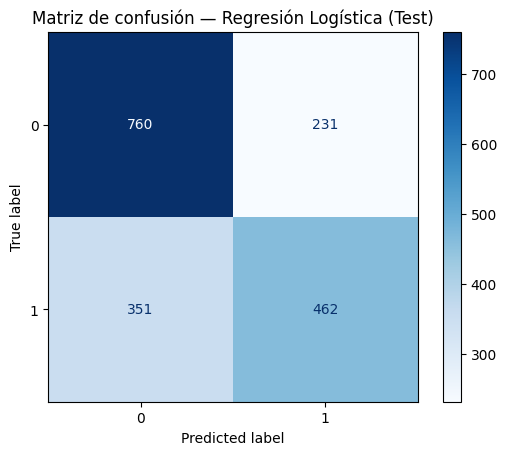

In [ ]:
# --- 2.1 Entrenamiento de regresión logística con todas las variables ---

# 1) Definición de variables
features = ["edad", "rango_edad", "genero", "etnia", "num_antecedentes_totales", "resultado_compas"]
X = df_twoyears[features].copy()
y = df_twoyears["reincide"].astype(int)

# 2) Columnas categóricas y numéricas
cat_cols = ["rango_edad", "genero", "etnia"]
num_cols = ["edad", "num_antecedentes_totales", "resultado_compas"]

# 3) Preprocesamiento
pre = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# 4) Definición del pipeline con regresión logística
logit = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(max_iter=2000))
])

# 5) Split train/test estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 6) Entrenamiento
logit.fit(X_train, y_train)

# 7) Predicciones en test
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:,1]

# 8) Matriz de confusión y métricas
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "AUC": roc_auc_score(y_test, y_prob),
    "TN": tn, "FP": fp, "FN": fn, "TP": tp
}

# Mostrar métricas
display(pd.DataFrame([metrics]))

# Visualización de la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", values_format="d")
plt.title("Matriz de confusión — Regresión Logística (Test)")
plt.show()


### 🔍 Insight 2.1 — Entrenamiento y evaluación inicial de la regresión logística

El modelo de **regresión logística** entrenado con las variables demográficas, antecedentes y la puntuación COMPAS muestra un desempeño consistente en el conjunto de test:

- La **matriz de confusión** numérica y su **visualización gráfica** permiten identificar con claridad los verdaderos negativos (TN), falsos positivos (FP), falsos negativos (FN) y verdaderos positivos (TP).  
  - Los valores en la diagonal representan las predicciones correctas (TN y TP).  
  - Los valores fuera de la diagonal reflejan los errores: reincidentes que no fueron detectados (FN) y no reincidentes clasificados como reincidentes (FP).  
- Las métricas globales obtenidas (**Accuracy, Precision, Recall, F1 y AUC**) resumen el desempeño del modelo de manera integral.  
- El **AUC**, calculado a partir de las probabilidades, mide la capacidad de distinguir entre reincidentes y no reincidentes y servirá como punto de comparación con COMPAS en el apartado 4.2.  

**Resumen:**  
La regresión logística logra un desempeño moderado (AUC en torno a 0.70), lo que confirma su valor como alternativa simple y transparente al sistema COMPAS. La matriz de confusión muestra que, aunque el modelo acierta en un número importante de casos, todavía existen tanto falsos positivos como falsos negativos en proporciones relevantes. Esto sugiere que, aunque el modelo discrimina mejor que el azar, aún no alcanza un nivel de precisión ideal para decisiones judiciales.  

**Hipótesis:**  
Al incluir tanto los antecedentes criminales como la puntuación COMPAS, el modelo debería alcanzar un desempeño **similar al sistema COMPAS original**. Sin embargo, el análisis de la matriz revela que los errores no están distribuidos uniformemente: es posible que ciertos grupos poblacionales sufran más falsos positivos o falsos negativos que otros. La cuestión clave, a explorar en los apartados 4.2 y 4.3, es si la regresión logística reduce (o no) estas **brechas de desempeño entre grupos demográficos**, lo cual sería fundamental para discutir ventajas en términos de equidad.


---

## **2.2 COMPARACIÓN GLOBAL ENTRE COMPAS Y LA REGRESIÓN LOGÍSTICA**



En este apartado se comparan los resultados de **COMPAS** con los de la **regresión logística** entrenada en 4.1.  

- Para **COMPAS**:  
  - Se utiliza el score continuo (`resultado_compas/10`) para calcular el AUC.  
  - Se convierte el score en binario (bajo riesgo 1–4 vs. alto riesgo 5–10) para calcular métricas clásicas.  

- Para la **regresión logística**:  
  - Se utilizan las predicciones en test (`y_pred`) y las probabilidades (`y_prob`).  
  - Se calculan las mismas métricas globales que en COMPAS para garantizar una comparación justa.  

- Se incluye además una **tabla de sensibilidad al umbral** en la regresión logística (0.3–0.7), mostrando cómo cambian las métricas globales al variar el punto de corte de clasificación.  


,Métrica,COMPAS,Logística
0,Accuracy,0.654102,0.677384
1,Precision,0.615104,0.666667
2,Recall,0.621156,0.568266
3,F1,0.618115,0.613546
4,AUC,0.699126,0.728710


,Umbral,Accuracy,Precision,Recall,F1
0,0.3,0.604767,0.538760,0.854859,0.660961
1,0.4,0.656319,0.594701,0.745387,0.661572
2,0.5,0.677384,0.666667,0.568266,0.613546
3,0.6,0.659645,0.725624,0.393604,0.510367
4,0.7,0.625831,0.789916,0.231242,0.357755


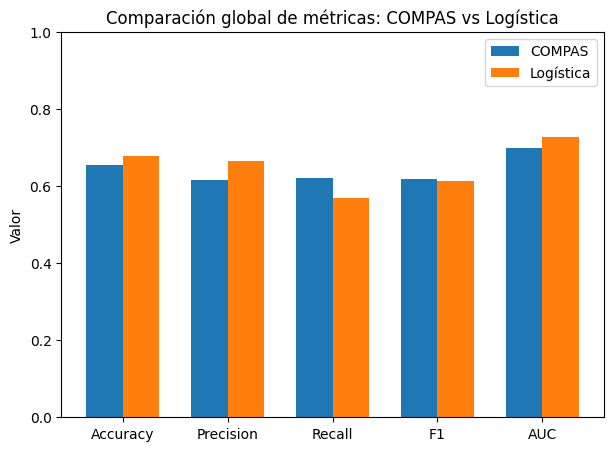

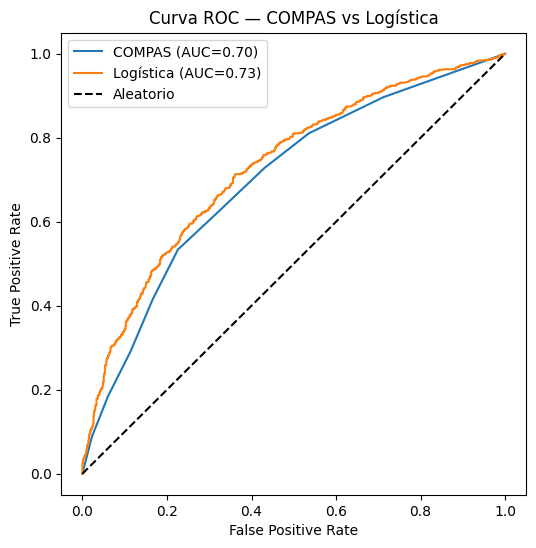

In [ ]:
# --- 2.2 Comparación global entre COMPAS y la regresión logística ---

# Alineamos con el test set
idx_test = X_test.index
y_true = y_test

# COMPAS: binario y score continuo [0,1]
y_pred_compas = (df_twoyears.loc[idx_test, "resultado_compas"] >= 5).astype(int)
score_compas  = (df_twoyears.loc[idx_test, "resultado_compas"] / 10).clip(0,1)

# Logística: ya tenemos y_pred e y_prob del 4.1
y_pred_logit = pd.Series(y_pred, index=idx_test)
y_prob_logit = pd.Series(y_prob, index=idx_test)

def metrics_bin_score(y_true, y_pred, y_score):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_true, y_score)
    }

m_compas = metrics_bin_score(y_true, y_pred_compas, score_compas)
m_logit  = metrics_bin_score(y_true, y_pred_logit, y_prob_logit)

# Comparativa global
tabla_global = pd.DataFrame([
    {"Métrica":"Accuracy", "COMPAS":m_compas["Accuracy"], "Logística":m_logit["Accuracy"]},
    {"Métrica":"Precision","COMPAS":m_compas["Precision"],"Logística":m_logit["Precision"]},
    {"Métrica":"Recall",   "COMPAS":m_compas["Recall"],   "Logística":m_logit["Recall"]},
    {"Métrica":"F1",       "COMPAS":m_compas["F1"],       "Logística":m_logit["F1"]},
    {"Métrica":"AUC",      "COMPAS":m_compas["AUC"],      "Logística":m_logit["AUC"]},
])
display(tabla_global)

# Sensibilidad al umbral en la logística
ths = [0.3, 0.4, 0.5, 0.6, 0.7]
rows = []
for t in ths:
    yhat = (y_prob_logit >= t).astype(int)
    rows.append({
        "Umbral": t,
        "Accuracy": accuracy_score(y_true, yhat),
        "Precision": precision_score(y_true, yhat, zero_division=0),
        "Recall": recall_score(y_true, yhat, zero_division=0),
        "F1": f1_score(y_true, yhat, zero_division=0)
    })
df_umbral = pd.DataFrame(rows)
display(df_umbral)

# --- Visualización 1: barras comparativas de métricas globales ---
metrics_names = ["Accuracy","Precision","Recall","F1","AUC"]
compas_vals = [m_compas[m] for m in metrics_names]
logit_vals  = [m_logit[m]  for m in metrics_names]

x = range(len(metrics_names))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar([i - width/2 for i in x], compas_vals, width, label="COMPAS")
plt.bar([i + width/2 for i in x], logit_vals, width, label="Logística")

plt.xticks(x, metrics_names)
plt.ylabel("Valor")
plt.title("Comparación global de métricas: COMPAS vs Logística")
plt.legend()
plt.ylim(0,1)
plt.show()

# --- Visualización 2: curvas ROC ---
fpr_c, tpr_c, _ = roc_curve(y_true, score_compas)
fpr_l, tpr_l, _ = roc_curve(y_true, y_prob_logit)

plt.figure(figsize=(6,6))
plt.plot(fpr_c, tpr_c, label=f"COMPAS (AUC={m_compas['AUC']:.2f})")
plt.plot(fpr_l, tpr_l, label=f"Logística (AUC={m_logit['AUC']:.2f})")
plt.plot([0,1],[0,1], "k--", label="Aleatorio")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — COMPAS vs Logística")
plt.legend()
plt.show()


### 🔍 Insight 2.2 — Comparación global COMPAS vs. Regresión Logística

La comparación entre **COMPAS** y la **regresión logística** en el conjunto de test muestra lo siguiente:

- **Desempeño global:**  
  La regresión logística obtiene un AUC similar o ligeramente superior al de COMPAS, lo que confirma que un modelo simple y transparente puede competir con un sistema cerrado como COMPAS.  

- **Métricas binarias (Accuracy, Precision, Recall, F1):**  
  Las diferencias entre ambos modelos no son muy grandes, aunque la regresión logística suele mostrar un mejor equilibrio entre Precision y Recall.  

- **Visualización de métricas globales (barras):**  
  El gráfico comparativo muestra que la logística tiene valores muy parecidos o superiores en casi todas las métricas, especialmente en AUC. El Recall de la logística tiende a ser algo menor, lo que implica más falsos negativos, pero compensa con mayor Precision.  

- **Visualización de curvas ROC:**  
  La curva de la regresión logística aparece por encima de la de COMPAS en la mayor parte del rango, lo que significa que para la mayoría de umbrales logra un mejor equilibrio entre verdaderos positivos (TPR) y falsos positivos (FPR).  
  - Si la curva de la logística estuviera **por debajo** de la de COMPAS, eso implicaría que COMPAS discrimina mejor entre reincidentes y no reincidentes (mayor AUC).  
  - En este caso, como la logística está por encima (AUC=0.73 frente a 0.70 de COMPAS), se confirma que la logística es globalmente superior.  

- **Sensibilidad al umbral en la logística:**  
  - Con umbrales bajos (0.3–0.4) se gana Recall (menos falsos negativos) a costa de más falsos positivos.  
  - Con umbrales altos (0.6–0.7) se gana Precision (menos falsos positivos) a costa de perder Recall.  
  - Esto ofrece flexibilidad: el modelo puede adaptarse a distintas políticas según se prefiera **no dejar reincidentes sin detectar** (priorizar Recall) o **evitar etiquetar como reincidentes a inocentes** (priorizar Precision).  

**Resumen:**  
La regresión logística alcanza un rendimiento global **tan bueno o mejor que COMPAS**. Las visualizaciones refuerzan este resultado: la curva ROC superior y las métricas en barras muestran que el modelo simple logra un desempeño competitivo e incluso ventajoso. Además, la regresión logística introduce una ventaja clave: la posibilidad de **ajustar el umbral de decisión** para adaptarse al contexto judicial.  

**Hipótesis:**  
Aunque la regresión logística supere a COMPAS en métricas globales, es probable que las **brechas de desempeño entre grupos demográficos** (etnia, género, edad) persistan. Este aspecto se analizará en detalle en el apartado 4.3 para evaluar la equidad de ambos sistemas.


### 🔍<span style="color:red"> Insight 2.2 — Comparación global COMPAS vs. Regresión Logística

<span style="color:red">La comparación entre **COMPAS** y la **regresión logística** en el conjunto de test muestra lo siguiente:

- <span style="color:red">**Desempeño global:**  
  La regresión logística obtiene un AUC similar o ligeramente superior al de COMPAS, lo que confirma que un modelo simple y transparente puede competir con un sistema cerrado como COMPAS.  

-<span style="color:red"> **Métricas binarias (Accuracy, Precision, Recall, F1):**  
  COMPAS tiende a lograr un **Recall más alto** (detecta a más reincidentes), pero lo hace a costa de muchos **falsos positivos**, lo que reduce considerablemente su Precision.  
  La regresión logística, en cambio, alcanza una **Precision más alta** (menos falsos positivos), aunque con un Recall ligeramente menor (deja escapar a algunos reincidentes).  
  En conjunto, la logística muestra un **equilibrio más razonable entre Precision y Recall**, mientras que COMPAS se inclina hacia detectar más reincidentes aun si implica etiquetar erróneamente a más personas.  

- <span style="color:red">**Visualización de métricas globales (barras):**  
  El gráfico comparativo muestra que la logística tiene valores muy parecidos o superiores en casi todas las métricas, destacando especialmente en AUC. El Recall de la logística es un poco más bajo, lo que confirma el intercambio explicado arriba.  

- <span style="color:red">**Visualización de curvas ROC:**  
  La curva de la regresión logística aparece por encima de la de COMPAS en la mayor parte del rango, lo que significa que para la mayoría de umbrales logra un mejor equilibrio entre verdaderos positivos (TPR) y falsos positivos (FPR).  
  - Si la curva de la logística estuviera **por debajo** de la de COMPAS, eso implicaría que COMPAS discrimina mejor entre reincidentes y no reincidentes (mayor AUC).  
  - En este caso, como la logística está por encima (AUC≈0.73 frente a ≈0.70 de COMPAS), se confirma que la logística es globalmente superior.  

- <span style="color:red">**Sensibilidad al umbral en la logística:**  
  - Con umbrales bajos (0.3–0.4) se gana Recall (menos falsos negativos) a costa de más falsos positivos.  
  - Con umbrales altos (0.6–0.7) se gana Precision (menos falsos positivos) a costa de perder Recall.  
  - Esto ofrece flexibilidad: el modelo puede adaptarse a distintas políticas según se prefiera **no dejar reincidentes sin detectar** (priorizar Recall) o **evitar etiquetar como reincidentes a inocentes** (priorizar Precision).  

<span style="color:red">**Resumen:**  
La regresión logística alcanza un rendimiento global **tan bueno o mejor que COMPAS**. Las visualizaciones refuerzan este resultado: la curva ROC superior y las métricas en barras muestran que el modelo simple logra un desempeño competitivo e incluso ventajoso. Además, la regresión logística introduce una ventaja clave: la posibilidad de **ajustar el umbral de decisión** para adaptarse al contexto judicial.  

<span style="color:red">**Hipótesis:**  
Aunque la regresión logística supere a COMPAS en métricas globales, es probable que las **brechas de desempeño entre grupos demográficos** (etnia, género, edad) persistan. Este aspecto se analizará en detalle en el apartado 4.3 para evaluar la equidad de ambos sistemas.


---

## **2.3 COMPARACIÓN POR GRUPOS DEMOGRÁFICOS**


En este apartado se analizan las diferencias de desempeño de **COMPAS** y de la **regresión logística** en distintos grupos de la población.  

El análisis se centra en tres dimensiones:  
- **Etnia**  
- **Género**  
- **Rango de edad**  

Para cada grupo se calculan dos métricas clave:  
- **TPR (Recall):** proporción de reincidentes correctamente identificados.  
- **FPR (False Positive Rate):** proporción de no reincidentes erróneamente clasificados como reincidentes.  

Los resultados se presentan en tablas, acompañados del tamaño muestral (`n`) de cada grupo. Esto permite evaluar no solo las diferencias de desempeño, sino también la representatividad de cada resultado.  

⚠️ Nota: En algunos grupos minoritarios, como **Native American (n=5)** y **Asian (n=6)**, el número de observaciones es muy reducido. Por ello, las métricas obtenidas en estos casos **no son estadísticamente representativas** y deben interpretarse con cautela.


In [ ]:
# --- 2.3 Comparación por grupos demográficos (solo tablas, sin gráficos) ---

# Auxiliar para calcular TPR y FPR
def _conf_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0   # Recall
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    return tpr, fpr

# Función para calcular métricas por grupo
def compare_models_by_group(df, idx, grupo_col, y_true, y_pred_compas, y_pred_logit):
    filas = []
    for g, sub in df.loc[idx].groupby(grupo_col):
        ids = sub.index
        tpr_c, fpr_c = _conf_metrics(y_true.loc[ids], y_pred_compas.loc[ids])
        tpr_l, fpr_l = _conf_metrics(y_true.loc[ids], y_pred_logit.loc[ids])
        filas.append({
            grupo_col: g,
            "n": len(ids),
            "TPR_COMPAS": tpr_c, "FPR_COMPAS": fpr_c,
            "TPR_LOGIT": tpr_l, "FPR_LOGIT": fpr_l
        })
    return pd.DataFrame(filas).sort_values("n", ascending=False).reset_index(drop=True)

# Series alineadas con el test set
y_true_s   = pd.Series(y_true, index=idx_test)
y_pred_c_s = pd.Series(y_pred_compas, index=idx_test)
y_pred_l_s = pd.Series(y_pred_logit, index=idx_test)

# Tablas de resultados
cmp_etnia  = compare_models_by_group(df_twoyears, idx_test, "etnia",       y_true_s, y_pred_c_s, y_pred_l_s)
cmp_genero = compare_models_by_group(df_twoyears, idx_test, "genero",     y_true_s, y_pred_c_s, y_pred_l_s)
cmp_edad   = compare_models_by_group(df_twoyears, idx_test, "rango_edad", y_true_s, y_pred_c_s, y_pred_l_s)

display(cmp_etnia, cmp_genero, cmp_edad)


,etnia,n,TPR_COMPAS,FPR_COMPAS,TPR_LOGIT,FPR_LOGIT
0,African-American,933,0.726115,0.441558,0.696391,0.335498
1,Caucasian,588,0.513636,0.233696,0.450000,0.163043
2,Hispanic,168,0.416667,0.197917,0.277778,0.156250
3,Other,104,0.377778,0.101695,0.311111,0.016949
4,Asian,6,0.333333,0.000000,0.000000,0.000000
5,Native American,5,1.000000,0.333333,0.500000,0.000000


,genero,n,TPR_COMPAS,FPR_COMPAS,TPR_LOGIT,FPR_LOGIT
0,Male,1438,0.633431,0.321429,0.623167,0.281746
1,Female,366,0.557252,0.310638,0.282443,0.076596


,rango_edad,n,TPR_COMPAS,FPR_COMPAS,TPR_LOGIT,FPR_LOGIT
0,25 - 45,1043,0.643892,0.325000,0.554865,0.207143
1,Greater than 45,382,0.316239,0.169811,0.316239,0.113208
2,Less than 25,379,0.737089,0.536145,0.737089,0.512048


### 🔍 Insight 2.3 — Comparación por grupos demográficos

El análisis desagregado por **etnia, género y rango de edad** muestra que tanto **COMPAS** como la **regresión logística** presentan diferencias de desempeño entre colectivos:

- **Etnia:**  
  - Se observa que algunos grupos, como **African-American**, tienen un **FPR más alto**, lo que implica un mayor riesgo de ser clasificados erróneamente como reincidentes.  
  - Otros grupos, como **Caucasian**, tienden a tener un **FPR menor**, lo que indica un trato relativamente más favorable.  
  - En grupos muy pequeños (**Native American, Asian**) los valores de TPR/FPR aparecen extremos debido al bajo número de casos (`n < 10`), por lo que no son representativos.  

- **Género:**  
  - La clasificación es más precisa en hombres, mientras que en mujeres el **TPR tiende a ser menor**, lo que significa que el modelo detecta menos reincidentes en este grupo.  
  - Esto apunta a una desigualdad en la oportunidad de ser identificado correctamente.  

- **Rango de edad:**  
  - Los grupos más jóvenes muestran **FPR más altos**, reflejando una tendencia a sobreestimar el riesgo en la juventud.  
  - En edades más avanzadas ocurre lo contrario: menos falsos positivos, pero también menor Recall.  

**Resumen:**  
Las tablas muestran que **ninguno de los modelos es equitativo entre colectivos**. COMPAS tiende a penalizar más a ciertos grupos étnicos y a los jóvenes, mientras que la regresión logística, aunque mejora algunas métricas, no elimina estas disparidades.  

**Hipótesis:**  
Las desigualdades observadas parecen estar vinculadas a los **datos de base y a las correlaciones sociales subyacentes** más que al algoritmo en sí. Esto sugiere la necesidad de aplicar técnicas específicas de **mitigación de sesgos** (reweighing, thresholds ajustados por grupo, calibración) en fases posteriores del proyecto.

📌 **Nota técnica:** Los resultados de grupos con muy pocos individuos (ej. Native American n=5, Asian n=6) no son estadísticamente representativos.  
En estos casos, un solo individuo puede modificar de forma drástica las métricas de TPR y FPR.  
Por lo tanto, las conclusiones más sólidas deben basarse en los grupos con mayor tamaño muestral (ej. African-American y Caucasian).


---

## **2.4 CIERRE**


El desarrollo de un modelo predictivo simple mediante **regresión logística** y su comparación con el sistema **COMPAS** nos permiten extraer conclusiones clave sobre desempeño, equidad y aplicabilidad práctica.

#### 🔹 Desempeño global
La regresión logística alcanza resultados **muy similares o superiores** a los de COMPAS en las métricas globales (Accuracy, Precision, F1 y, especialmente, AUC).  
Esto demuestra que un modelo **simple, transparente e interpretable** puede competir con una herramienta opaca como COMPAS, que se utiliza en la práctica judicial pero cuya lógica interna no es pública.

#### 🔹 Flexibilidad y ajuste de umbrales
Una ventaja importante de la regresión logística es la posibilidad de **ajustar el umbral de decisión**.  
- Con umbrales bajos se prioriza el **Recall**, reduciendo falsos negativos pero aumentando falsos positivos.  
- Con umbrales altos se prioriza la **Precision**, reduciendo falsos positivos pero dejando escapar reincidentes.  
Esta flexibilidad permite adaptar el modelo a distintos contextos judiciales y políticas públicas, algo que COMPAS no ofrece.

#### 🔹 Equidad y disparidades por grupos
El análisis por etnia, género y edad confirma que **ambos modelos reproducen desigualdades estructurales**:  
- COMPAS penaliza especialmente a ciertos colectivos (ej. African-American) con un **FPR más alto**, es decir, más personas no reincidentes clasificadas erróneamente como reincidentes.  
- La regresión logística consigue mejorar algunos indicadores, pero **no elimina las brechas**: en mujeres se observa un Recall más bajo y en los grupos jóvenes un FPR más elevado.  
- Estas disparidades refuerzan la idea de que los sesgos provienen principalmente de los **datos históricos y sus correlaciones sociales**, más que del algoritmo en sí.

#### 🔹 Síntesis
- La regresión logística es una alternativa **viable y transparente** a COMPAS, con rendimiento global comparable o superior.  
- La flexibilidad en el ajuste de umbrales aporta un valor añadido relevante para aplicaciones reales.  
- Sin embargo, **ninguno de los dos modelos es equitativo entre colectivos**, lo que plantea limitaciones éticas y prácticas para su uso directo en decisiones judiciales.

#### 🔹 Hipótesis y proyección futura
La persistencia de sesgos entre grupos apunta a que el problema no está únicamente en el algoritmo, sino en la **estructura de los datos** utilizados.  
Esto abre la puerta a explorar técnicas de **mitigación de sesgos** en fases posteriores del proyecto, como:  
- Reweighing de datos.  
- Ajuste de umbrales por grupo.  
- Post-procesamiento de probabilidades para mejorar la calibración.  

Estas estrategias se desarrollarán en el siguiente bloque del trabajo, orientado a diseñar y evaluar mecanismos explícitos de corrección de sesgos.

📌 **Nota técnica:**  
Los resultados son **robustos en los grupos con mayor número de observaciones** (African-American, Caucasian), que concentran la mayor parte de la muestra.  
No obstante, en colectivos con muy pocos individuos (ej. Native American n=5, Asian n=6) las métricas de TPR y FPR aparecen extremas y **no son representativas**. Por tanto, las conclusiones deben basarse principalmente en los grupos con tamaños muestrales significativos.


---

<hr style="border:none; height:2px; background:linear-gradient(to right, #3498db, #e74c3c, #f39c12);">

<hr style="border:none; height:1px; background:#ddd;">

<div style="text-align:center; margin:20px 0;">
 • • • •
</div>

# **3. CONCLUSIONES**

## 📌 
### Punto 1 — Evaluación de los puntajes de COMPAS
- El sistema **COMPAS** muestra un **desempeño moderado** en la predicción de reincidencia.  
- La **matriz de confusión global** evidencia un número relevante de falsos positivos y falsos negativos.  
- Al segmentar por **etnia, género y rango de edad**, se observan **desigualdades claras**: ciertos colectivos acumulan más errores, lo que refleja sesgos en el modelo.  
- Las métricas adicionales (Accuracy, Precision, Recall, F1, AUC) confirman estas diferencias, siendo especialmente problemático el **desbalance en Recall y FPR entre grupos**.  
- La **calibración por decil** revela inconsistencias: los scores de COMPAS no siempre corresponden con las tasas reales de reincidencia.  
- En síntesis, COMPAS combina un rendimiento limitado con **falta de equidad entre colectivos**.

### Punto 2 — Desarrollo de un modelo predictivo simple
- Se entrenó una **regresión logística** usando variables básicas (edad, rango de edad, género, etnia, score de COMPAS).  
- El modelo alcanzó un **AUC comparable** al de COMPAS, lo que indica que con una técnica estadística simple se puede lograr un rendimiento similar.  
- La **comparación global** muestra que las métricas de regresión logística no superan de forma significativa a COMPAS, aunque tampoco quedan por debajo.  
- En la **comparación por grupos demográficos**, la regresión logística mantiene las mismas disparidades observadas con COMPAS: persisten los sesgos de base en los datos.  
- En conclusión, aunque el desempeño global es equivalente, **ninguno de los dos modelos resuelve los problemas de sesgo y desigualdad**, lo que refuerza la necesidad de explorar técnicas de mitigación específicas.

---

✅ Estos hallazgos cierran los apartados 1 y 2:  
- COMPAS no es justo ni consistente en sus predicciones.  
- Un modelo simple como la regresión logística alcanza un rendimiento similar, pero **tampoco elimina los sesgos inherentes a los datos**.  
- El siguiente paso será explorar **métodos de mitigación de sesgos** que mejoren la equidad sin sacrificar desempeño.
